Used Google Collab

In [1]:
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cv2 as cv

import json

In [2]:
print(f"TENSORFLOW VERSION: {tf.__version__}")
print(f"DEVICE : {tf.test.gpu_device_name()}")

TENSORFLOW VERSION: 2.12.0
DEVICE : /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_path = './drive/MyDrive/data/train/'
val_path = './drive/MyDrive/data/val/'
test_path = './drive/MyDrive/data/test/'

In [ ]:
image_dimensions = {
    "width":[],
    "height":[],
    "color_channels":[]
}

image_names = os.listdir(train_path)
for image_name in image_names:
    height,width,color_channels = cv.imread(f"{train_path}{os.sep}{image_name}").shape
    image_dimensions["width"].append(width)
    image_dimensions["height"].append(height)
    image_dimensions["color_channels"].append(color_channels)

images_data = pd.DataFrame(image_dimensions)
images_data.head(5)

,width,height,color_channels
0,151,145,3
1,127,142,3
2,112,112,3
3,145,154,3
4,166,145,3


In [ ]:
images_data.describe()

,width,height,color_channels
count,16544.000000,16544.000000,16544.0
mean,132.598706,133.051136,3.0
std,20.026783,20.589782,0.0
min,46.000000,40.000000,3.0
25%,121.000000,121.000000,3.0
50%,130.000000,130.000000,3.0
75%,142.000000,145.000000,3.0
max,364.000000,346.000000,3.0


In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 64

<br/>
<br/>
<br/>

## CREATING INPUT PIPELINE

In [6]:
def preprocess_image(image_path):
    label = tf.strings.split(image_path,sep="/")[-1]
    label = tf.strings.split(label,sep="_")[0]
    label = tf.strings.to_number(label,out_type=tf.dtypes.float32)

    image_string =tf.io.read_file(image_path)
    image = tf.io.decode_png(image_string,channels=3,dtype=tf.dtypes.uint8)
    image = tf.cast(image,dtype=tf.dtypes.float32)
    image = image/255
    image = tf.image.resize(image,(IMAGE_SIZE,IMAGE_SIZE))

    return (image,label)

In [7]:
train_file_names = tf.constant([os.path.join(train_path,file_name) for file_name in os.listdir(train_path)])
train_file_names = tf.data.Dataset.from_tensor_slices((train_file_names))

train_dataset = train_file_names.map(preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_file_names))
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE , drop_remainder=False)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [8]:
val_file_names = tf.constant([os.path.join(val_path,file_name) for file_name in os.listdir(val_path)])
val_file_names = tf.data.Dataset.from_tensor_slices((val_file_names))

val_dataset = val_file_names.map(preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE , drop_remainder=False)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [9]:
test_file_names = tf.constant([os.path.join(test_path,file_name) for file_name in os.listdir(test_path)])
test_file_names = tf.data.Dataset.from_tensor_slices((test_file_names))

test_dataset = test_file_names.map(preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=BATCH_SIZE , drop_remainder=False)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [10]:
print(f"TOTAL TRAINING BATCHES: {len(train_dataset)}")
print(f"TOTAL VALIDATION BATCHES: {len(val_dataset)}")
print(f"TOTAL TESTING BATCHES: {len(test_dataset)}")

TOTAL TRAINING BATCHES: 259
TOTAL VALIDATION BATCHES: 52
TOTAL TESTING BATCHES: 121


In [ ]:
for images,labels in train_dataset.take(1):
    image = images[0].numpy()
    label = labels[0].numpy()

    print(f"WIDTH: {image.shape[0]}    HEIGHT:{image.shape[1]}")
    print(label)

WIDTH: 128    HEIGHT:128
0.0


<br/>
<br/>
<br/>
<br/>

## BUILDING MODELS

In [11]:
from tensorflow import keras

from tensorflow.keras.layers import Conv2D , AveragePooling2D , Dense , InputLayer , Flatten , BatchNormalization , MaxPooling2D , Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model

from sklearn.metrics import roc_curve, auc , accuracy_score ,confusion_matrix , log_loss

import time

In [12]:
def train_test_model( model , model_name  , is_batchnorm_used ):

  model_save_path = './drive/MyDrive/data'

  # Compiling model
  model.compile(optimizer='Adam',loss=BinaryCrossentropy() , metrics='accuracy')

  # Applying callbacks
  early_stopping = EarlyStopping(monitor='val_loss',patience=2,verbose=1)
  model_checkpoint = ModelCheckpoint( f"{model_save_path}{os.sep}best_{model_name}_{IMAGE_SIZE}.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  callbacks_list = [ early_stopping , model_checkpoint ]

  # Fitting the model
  start_time = time.time()
  history = model.fit(train_dataset , validation_data=val_dataset , epochs=100 , callbacks = callbacks_list)
  time_taken = time.time() - start_time

  # Loading the best model
  model = load_model(f"{model_save_path}{os.sep}best_{model_name}_{IMAGE_SIZE}.h5")

  # Calculating test probability
  test_data_probabilities = model.predict(test_dataset)
  test_data_probabilities = np.reshape( test_data_probabilities , (len(test_data_probabilities)) )

  # Getting true test labels
  true_test_labels = np.array([])
  for images, labels in test_dataset.take(-1):
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    true_test_labels = np.hstack((true_test_labels,numpy_labels))

  # Getting training and validation losses and accuracies
  train_loss = history.history["loss"]
  train_accuracy = history.history["accuracy"]
  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy"]

  # Saving the model parameters
  model_info = {
    "model_name" : model_name,
    "Bacth Normalization" : is_batchnorm_used,

    "train_loss" :train_loss[-1] ,
    "train_acc":train_accuracy[-1] ,

    "val_acc": val_accuracy[-1],
    "val_loss": val_loss[-1],

    "test_loss": log_loss(true_test_labels,test_data_probabilities),
    "test_acc": accuracy_score(true_test_labels,np.where(test_data_probabilities>0.5,1,0)),

    "time_taken":time_taken,
    "model_save_path": f"{model_save_path}{os.sep}best_{model_name}_{IMAGE_SIZE}.h5",
    "image_size":(IMAGE_SIZE,IMAGE_SIZE)
  }
  with open(f"{model_save_path}{os.sep}best_{model_name}_{IMAGE_SIZE}.json", "w") as outfile:
    json.dump(model_info, outfile)

  return test_data_probabilities , true_test_labels , train_loss , train_accuracy , val_loss , val_accuracy


In [13]:
def plot_train_vs_val(train_loss,train_accuracy,val_loss,val_accuracy):

  plt.rcParams["figure.figsize"] = [8, 5]
  fig,ax = plt.subplots(nrows=1,ncols=2)
  ax[0].plot(train_loss,label="train loss")
  ax[0].plot(val_loss,label="val loss")
  ax[0].set_title("train_loss VS val_loss")
  ax[0].legend()

  ax[1].plot(train_accuracy,label="train acc")
  ax[1].plot(val_accuracy,label="val acc")
  ax[1].set_title("train_accuracy VS val_accuracy")
  ax[1].legend()




def make_confusion_matrix(test_prob , true_test_labels):
  test_pred = np.where(test_prob>0.5,1,0)
  conf_mat = confusion_matrix(true_test_labels,test_pred)

  plt.figure(1, figsize=(9, 6))

  plt.title("Confusion Matrix")

  sns.set(font_scale=1.4)
  ax = sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})

  labels = ['Uninfected','Parasitized']
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)

  ax.set(ylabel="True Label", xlabel="Predicted Label")






def make_roc_auc_curve(true_test_labels,test_prob):
    fpr, tpr, thresholds = roc_curve(true_test_labels, np.where(test_prob>0.5,1,0))
    plt.plot(fpr, tpr,color="black")
    plt.plot([0,1],[0,1],color="red")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

<br/>
<br/>
<br/>
<br/>
<br/>

# LeNet Model without BatchNormalization

In [14]:
# https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/
tf.random.set_seed(42)

LeNet_model_without_batchnorm = tf.keras.Sequential()

LeNet_model_without_batchnorm.add( InputLayer( input_shape = (IMAGE_SIZE,IMAGE_SIZE,3) ) )

LeNet_model_without_batchnorm.add( Conv2D(filters=6 , kernel_size=(5,5) , strides=(1,1) , activation='relu' , padding='valid') )
LeNet_model_without_batchnorm.add( AveragePooling2D(pool_size=(2,2) , strides=(2,2) ) )

LeNet_model_without_batchnorm.add( Conv2D(filters=16 , kernel_size=(5,5) , strides=(1,1) , activation='relu' , padding='valid') )
LeNet_model_without_batchnorm.add( AveragePooling2D(pool_size=(2,2) , strides=(2,2) ) )

LeNet_model_without_batchnorm.add( Conv2D(filters=120 , kernel_size=(5,5) , strides=(1,1) , activation='relu' , padding='valid') )

LeNet_model_without_batchnorm.add( Flatten() )

LeNet_model_without_batchnorm.add( Dense(units=84 , activation='relu') )
LeNet_model_without_batchnorm.add( Dense(units=1 , activation='sigmoid') )

LeNet_model_without_batchnorm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 126, 126, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 16)      2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 61, 61, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 120)       48120     
                                                                 
 flatten (Flatten)           (None, 389880)            0

In [ ]:
print("DEVICE: ",tf.test.gpu_device_name())
test_data_probabilities , true_test_labels , train_loss , train_accuracy , val_loss , val_accuracy = train_test_model( model = LeNet_model_without_batchnorm , model_name = "Lenet_model_without_batchnorm" , is_batchnorm_used = False )

DEVICE:  /device:GPU:0
Epoch 1/100


In [ ]:
plot_train_vs_val(train_loss,train_accuracy,val_loss,val_accuracy)

In [ ]:
plt.figure(figsize=(5,5))
make_confusion_matrix(test_data_probabilities,true_test_labels)

In [ ]:
make_roc_auc_curve(true_test_labels,test_data_probabilities)

<br/>
<br/>
<br/>

## LeNet With BatchNormalization

In [19]:
# https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/
tf.random.set_seed(42)

LeNet_model_with_batchnorm = tf.keras.Sequential()

LeNet_model_with_batchnorm.add( InputLayer( input_shape = (IMAGE_SIZE,IMAGE_SIZE,3) ) )

LeNet_model_with_batchnorm.add( Conv2D(filters=6 , kernel_size=(5,5) , strides=(1,1) , activation='relu' , padding='valid') )
LeNet_model_with_batchnorm.add( BatchNormalization())
LeNet_model_with_batchnorm.add( AveragePooling2D(pool_size=(2,2) , strides=(2,2) ) )

LeNet_model_with_batchnorm.add( Conv2D(filters=16 , kernel_size=(5,5) , strides=(1,1) , activation='relu' , padding='valid') )
LeNet_model_with_batchnorm.add( BatchNormalization())
LeNet_model_with_batchnorm.add( AveragePooling2D(pool_size=(2,2) , strides=(2,2) ) )

LeNet_model_with_batchnorm.add( Conv2D(filters=120 , kernel_size=(5,5) , strides=(1,1) , activation='relu' , padding='valid') )
LeNet_model_with_batchnorm.add( BatchNormalization())

LeNet_model_with_batchnorm.add( Flatten() )

LeNet_model_with_batchnorm.add( Dense(units=84 , activation='relu') )
LeNet_model_with_batchnorm.add( BatchNormalization())
LeNet_model_with_batchnorm.add( Dense(units=1 , activation='sigmoid') )

LeNet_model_with_batchnorm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 6)      24        
 ormalization)                                                   
                                                                 
 average_pooling2d_2 (Averag  (None, 62, 62, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 batch_normalization_1 (Batc  (None, 58, 58, 16)       64        
 hNormalization)                                                 
                                                      

In [20]:
print("DEVICE: ",tf.test.gpu_device_name())
test_data_probabilities , true_test_labels , train_loss , train_accuracy , val_loss , val_accuracy = train_test_model( model = LeNet_model_with_batchnorm , model_name = "Lenet_model_with_batchnorm" , is_batchnorm_used = True)

DEVICE:  /device:GPU:0
Epoch 1/100
258/259 [============================>.] - ETA: 0s - loss: 0.4721 - accuracy: 0.8010
Epoch 1: val_accuracy improved from -inf to 0.50076, saving model to ./drive/MyDrive/data/best_Lenet_model_with_batchnorm_128.h5
259/259 [==============================] - 22s 68ms/step - loss: 0.4720 - accuracy: 0.8011 - val_loss: 1.8393 - val_accuracy: 0.5008
Epoch 2/100
258/259 [============================>.] - ETA: 0s - loss: 0.1790 - accuracy: 0.9350
Epoch 2: val_accuracy improved from 0.50076 to 0.85334, saving model to ./drive/MyDrive/data/best_Lenet_model_with_batchnorm_128.h5
259/259 [==============================] - 12s 47ms/step - loss: 0.1791 - accuracy: 0.9348 - val_loss: 0.3975 - val_accuracy: 0.8533
Epoch 3/100
257/259 [============================>.] - ETA: 0s - loss: 0.1513 - accuracy: 0.9471
Epoch 3: val_accuracy improved from 0.85334 to 0.91533, saving model to ./drive/MyDrive/data/best_Lenet_model_with_batchnorm_128.h5
259/259 [==================

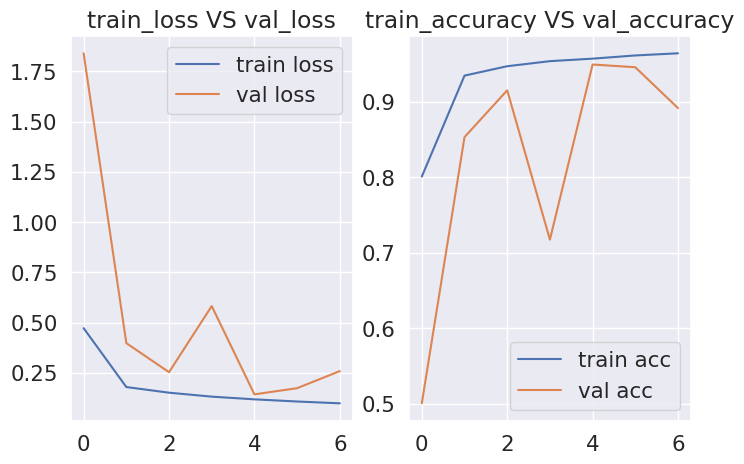

In [21]:
plot_train_vs_val(train_loss,train_accuracy,val_loss,val_accuracy)

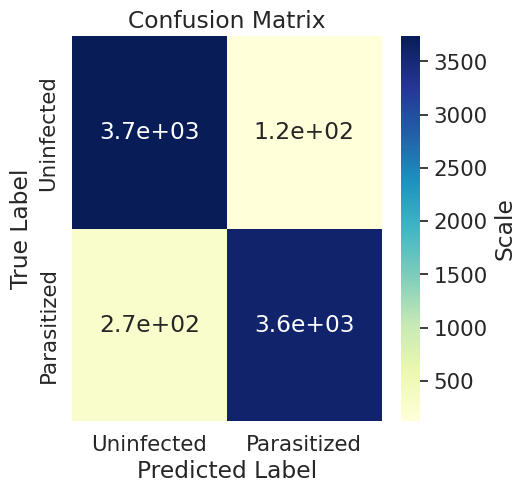

In [22]:
plt.figure(figsize=(5,5))
make_confusion_matrix(test_data_probabilities,true_test_labels)

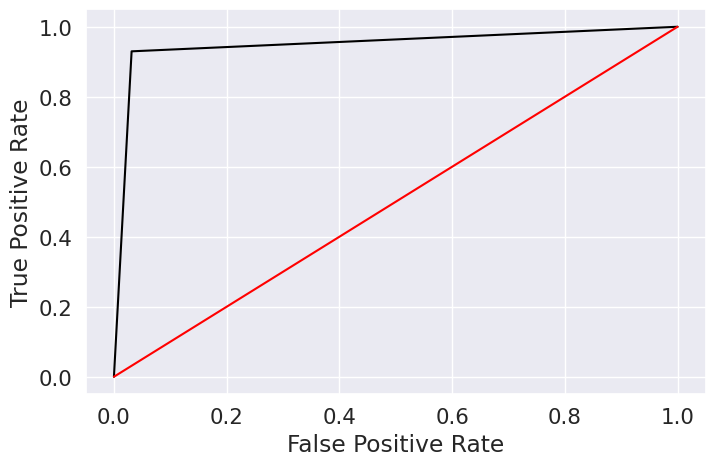

In [23]:
make_roc_auc_curve(true_test_labels,test_data_probabilities)

<br/>
<br/>
<br/>
<br/>

# AlexNet without BatchNormalization

https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/

In [25]:
AlexNet_model_without_batchnorm = tf.keras.Sequential()
AlexNet_model_without_batchnorm.add( InputLayer( input_shape = (IMAGE_SIZE,IMAGE_SIZE,3) ) )

AlexNet_model_without_batchnorm.add( Conv2D(filters=96 , kernel_size=(11,11) , strides=4 , activation='relu' , padding='same') )
AlexNet_model_without_batchnorm.add( MaxPooling2D( pool_size=(3,3) , strides=2 ) )

AlexNet_model_without_batchnorm.add( Conv2D(filters=256 , kernel_size=(5,5) , strides=1 , activation='relu' , padding='same') )
AlexNet_model_without_batchnorm.add( MaxPooling2D( pool_size=(3,3) , strides=2 ) )

AlexNet_model_without_batchnorm.add( Conv2D(filters=384 , kernel_size=(3,3) , strides=1 , activation='relu' , padding='same') )
AlexNet_model_without_batchnorm.add( Conv2D(filters=384 , kernel_size=(3,3) , strides=1 , activation='relu' , padding='same') )
AlexNet_model_without_batchnorm.add( Conv2D(filters=256 , kernel_size=(3,3) , strides=1 , activation='relu' , padding='same') )
AlexNet_model_without_batchnorm.add( MaxPooling2D( pool_size=(3,3) , strides=2 ) )

AlexNet_model_without_batchnorm.add( Dropout(0.5) )

AlexNet_model_without_batchnorm.add(Flatten())

AlexNet_model_without_batchnorm.add( Dropout(0.5) )
AlexNet_model_without_batchnorm.add( Dense(units=100,activation='relu') )
AlexNet_model_without_batchnorm.add( Dropout(0.5) )
AlexNet_model_without_batchnorm.add( Dense(units=100,activation='relu') )
AlexNet_model_without_batchnorm.add( Dense(units=1,activation='sigmoid') )

AlexNet_model_without_batchnorm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 96)        34944     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 96)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 15, 15, 256)       614656    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 384)         885120    
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 384)        

In [26]:
print("DEVICE: ",tf.test.gpu_device_name())
test_data_probabilities , true_test_labels , train_loss , train_accuracy , val_loss , val_accuracy = train_test_model( model = AlexNet_model_without_batchnorm , model_name = "AlexNet_model_without_batchnorm" , is_batchnorm_used = False)

DEVICE:  /device:GPU:0
Epoch 1/100
259/259 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.5027
Epoch 1: val_accuracy improved from -inf to 0.50015, saving model to ./drive/MyDrive/data/best_AlexNet_model_without_batchnorm_128.h5
259/259 [==============================] - 18s 54ms/step - loss: 0.6942 - accuracy: 0.5027 - val_loss: 0.6935 - val_accuracy: 0.5002
Epoch 2/100
257/259 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.4996
Epoch 2: val_accuracy did not improve from 0.50015
259/259 [==============================] - 13s 49ms/step - loss: 0.6933 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 3/100
257/259 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5015
Epoch 3: val_accuracy did not improve from 0.50015
259/259 [==============================] - 13s 49ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 4/100
257/259 [============================>.

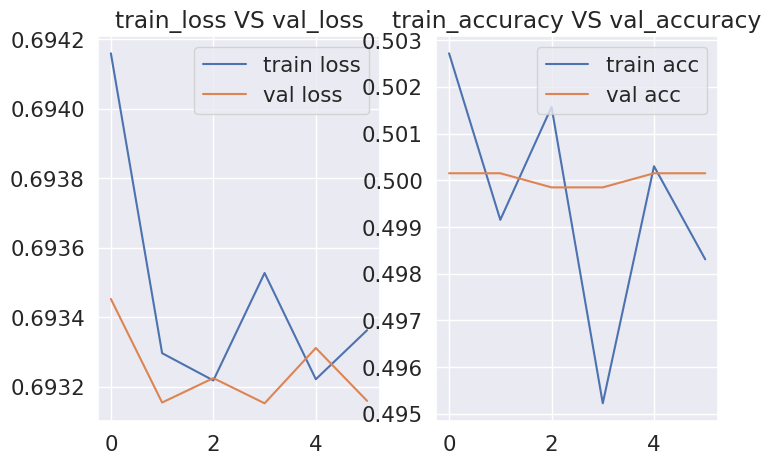

In [27]:
plot_train_vs_val(train_loss,train_accuracy,val_loss,val_accuracy)

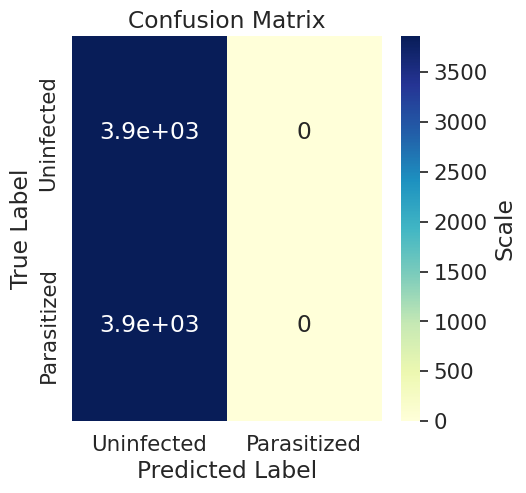

In [28]:
plt.figure(figsize=(5,5))
make_confusion_matrix(test_data_probabilities,true_test_labels)

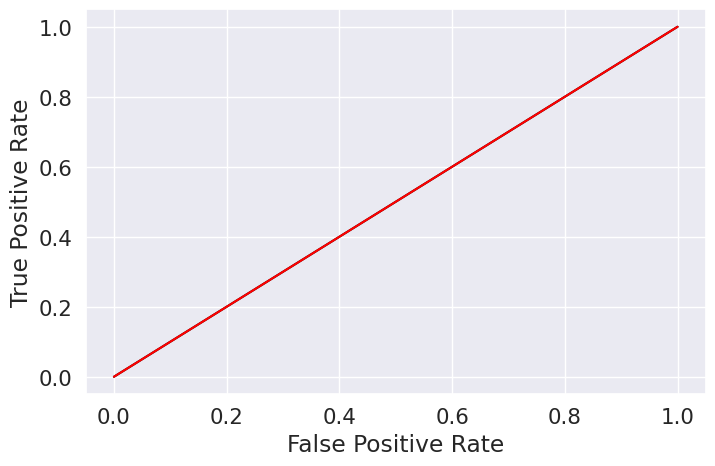

In [29]:
make_roc_auc_curve(true_test_labels,test_data_probabilities)

<br/>
<br/>
<br/>
<br/>

# AlexNet with BatchNormalization

In [30]:
AlexNet_model_with_batchnorm = tf.keras.Sequential()
AlexNet_model_with_batchnorm.add( InputLayer( input_shape = (IMAGE_SIZE,IMAGE_SIZE,3) ) )

AlexNet_model_with_batchnorm.add( Conv2D(filters=96 , kernel_size=(11,11) , strides=4 , activation='relu' , padding='same') )
AlexNet_model_with_batchnorm.add( BatchNormalization())
AlexNet_model_with_batchnorm.add( MaxPooling2D( pool_size=(3,3) , strides=2 ) )

AlexNet_model_with_batchnorm.add( Conv2D(filters=256 , kernel_size=(5,5) , strides=1 , activation='relu' , padding='same') )
AlexNet_model_with_batchnorm.add( BatchNormalization())
AlexNet_model_with_batchnorm.add( MaxPooling2D( pool_size=(3,3) , strides=2 ) )

AlexNet_model_with_batchnorm.add( Conv2D(filters=384 , kernel_size=(3,3) , strides=1 , activation='relu' , padding='same') )
AlexNet_model_with_batchnorm.add( BatchNormalization())
AlexNet_model_with_batchnorm.add( Conv2D(filters=384 , kernel_size=(3,3) , strides=1 , activation='relu' , padding='same') )
AlexNet_model_with_batchnorm.add( BatchNormalization())
AlexNet_model_with_batchnorm.add( Conv2D(filters=256 , kernel_size=(3,3) , strides=1 , activation='relu' , padding='same') )
AlexNet_model_with_batchnorm.add( BatchNormalization())
AlexNet_model_with_batchnorm.add( MaxPooling2D( pool_size=(3,3) , strides=2 ) )

AlexNet_model_with_batchnorm.add( Dropout(0.5) )

AlexNet_model_with_batchnorm.add(Flatten())

AlexNet_model_with_batchnorm.add( Dropout(0.5) )
AlexNet_model_with_batchnorm.add( Dense(units=100,activation='relu') )
AlexNet_model_with_batchnorm.add( BatchNormalization())
AlexNet_model_with_batchnorm.add( Dropout(0.5) )
AlexNet_model_with_batchnorm.add( Dense(units=100,activation='relu') )
AlexNet_model_with_batchnorm.add( BatchNormalization())
AlexNet_model_with_batchnorm.add( Dense(units=1,activation='sigmoid') )

AlexNet_model_with_batchnorm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 96)        34944     
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 96)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 15, 15, 256)       614656    
                                                                 
 batch_normalization_5 (Batc  (None, 15, 15, 256)      1024      
 hNormalization)                                                 
                                                      

In [31]:
print("DEVICE: ",tf.test.gpu_device_name())
test_data_probabilities , true_test_labels , train_loss , train_accuracy , val_loss , val_accuracy = train_test_model( model = AlexNet_model_with_batchnorm , model_name = "AlexNet_model_with_batchnorm" , is_batchnorm_used = True)

DEVICE:  /device:GPU:0
Epoch 1/100
259/259 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.7357
Epoch 1: val_accuracy improved from -inf to 0.52767, saving model to ./drive/MyDrive/data/best_AlexNet_model_with_batchnorm_128.h5
259/259 [==============================] - 20s 56ms/step - loss: 0.5408 - accuracy: 0.7357 - val_loss: 6.5690 - val_accuracy: 0.5277
Epoch 2/100
259/259 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.9063
Epoch 2: val_accuracy improved from 0.52767 to 0.71787, saving model to ./drive/MyDrive/data/best_AlexNet_model_with_batchnorm_128.h5
259/259 [==============================] - 16s 62ms/step - loss: 0.2616 - accuracy: 0.9063 - val_loss: 0.7213 - val_accuracy: 0.7179
Epoch 3/100
259/259 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9368
Epoch 3: val_accuracy improved from 0.71787 to 0.93317, saving model to ./drive/MyDrive/data/best_AlexNet_model_with_batchnorm_128.h5
259/259 [============

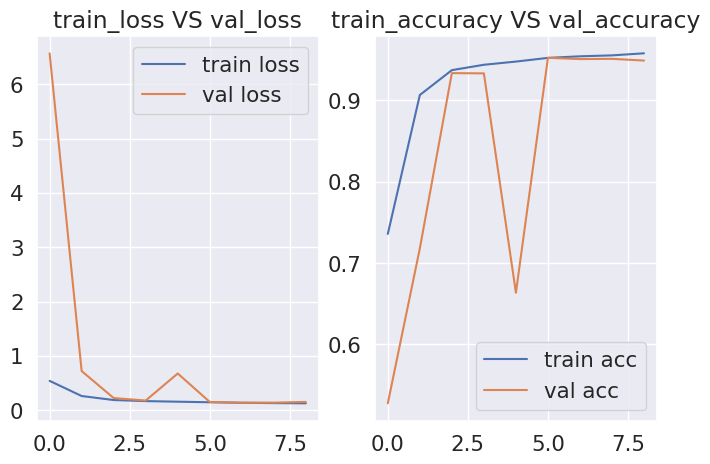

In [32]:
plot_train_vs_val(train_loss,train_accuracy,val_loss,val_accuracy)

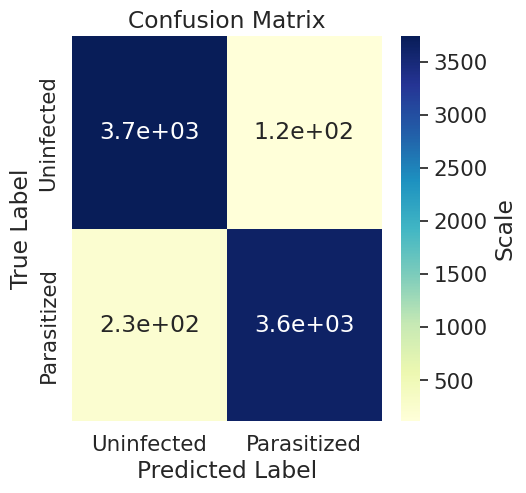

In [33]:
plt.figure(figsize=(5,5))
make_confusion_matrix(test_data_probabilities,true_test_labels)

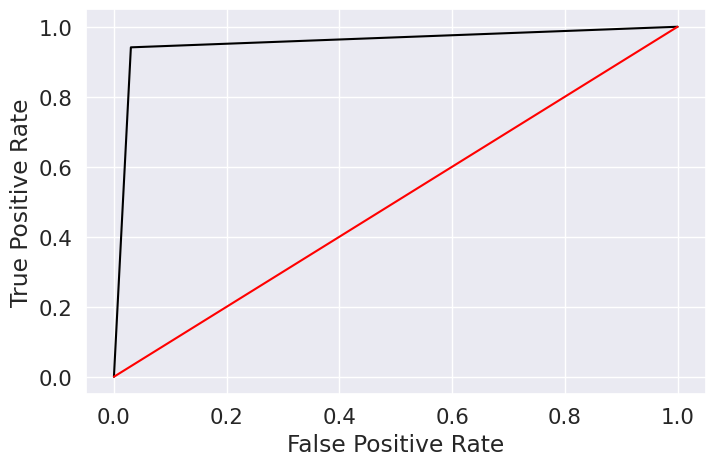

In [34]:
make_roc_auc_curve(true_test_labels,test_data_probabilities)

<br/>
<br/>
<br/>

# COMPARING PERFORMANCES

In [3]:
performance_path = f"./performances"
models_performaces_list = os.listdir(performance_path)
models_performaces_list

['best_AlexNet_model_without_batchnorm_128.json',
 'best_AlexNet_model_with_batchnorm_128.json',
 'best_Lenet_model_without_batchnorm_128.json',
 'best_Lenet_model_with_batchnorm_128.json']

In [4]:
model_names = []

test_accuracies = []
train_accuracies = []
val_accuracies = []

test_loss = []
train_loss = []
val_loss = []

time_taken = []

for file_name in models_performaces_list:
    file = open(f"{performance_path}{os.sep}{file_name}")
    data = json.load(file)

    model_names.append(data["model_name"])

    test_accuracies.append(data["test_acc"])
    train_accuracies.append(data["train_acc"])
    val_accuracies.append(data["val_acc"])

    test_loss.append(data["test_loss"])
    train_loss.append(data["train_loss"])
    val_loss.append(data["val_loss"])

    time_taken.append(data["time_taken"])

<AxesSubplot:>

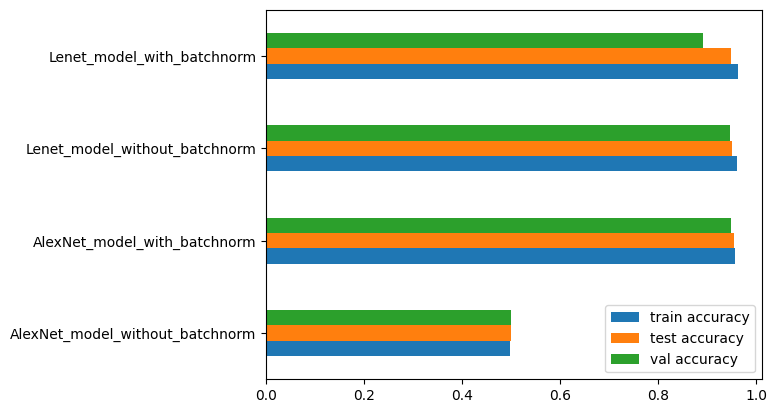

In [22]:
pd.DataFrame({"model name": model_names ,"train accuracy":train_accuracies , "test accuracy":test_accuracies , "val accuracy":val_accuracies},index=model_names).plot.barh()

<AxesSubplot:>

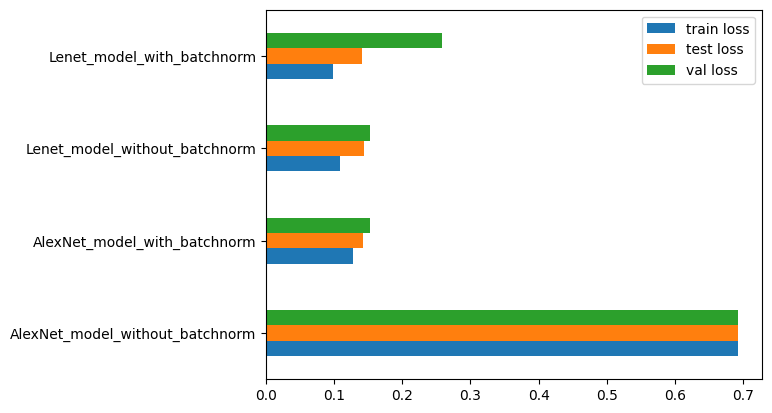

In [24]:
pd.DataFrame({"model name": model_names ,"train loss":train_loss , "test loss":test_loss , "val loss":val_loss},index=model_names).plot.barh()

<AxesSubplot:>

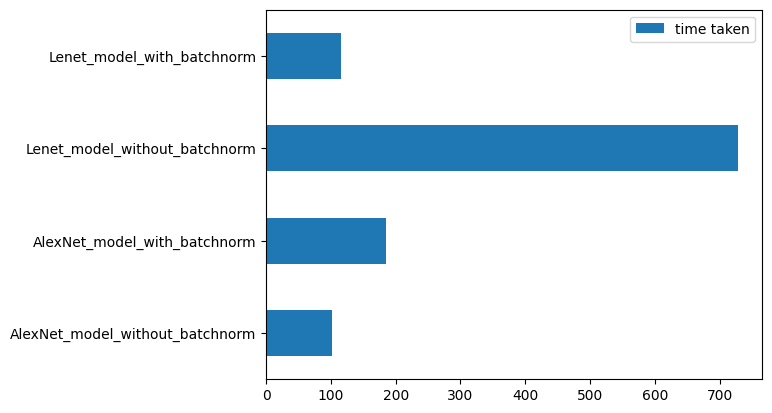

In [23]:
pd.DataFrame({"model name":model_names,"time taken":time_taken},index=model_names).plot.barh()